### Gender Bias Detection and Fairness Evaluation using Fairlearn on the Cardiovascular Disease Dataset
(Source: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset/data)

In [30]:
#installation
!pip install fairlearn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\patri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [31]:
# import libraries
from fairlearn.metrics import (
    MetricFrame, selection_rate,
    false_positive_rate, false_negative_rate,
    true_positive_rate, true_negative_rate,
    demographic_parity_difference, equalized_odds_difference
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss
)

### Bias detection for KNN

In [32]:
import pandas as pd

# Load KNN results
knn_df = pd.read_csv("CVDKaggleData_75M25F_PCAKNN_predictions.csv")

print(knn_df.head())

   gender  y_true  y_prob  y_pred
0       0       0    0.40       0
1       0       0    0.75       1
2       1       0    0.20       0
3       0       0    0.40       0
4       0       0    1.00       1


In [33]:
# Extract common columns
y_true_knn = knn_df["y_true"].values
y_prob_knn = knn_df["y_prob"].values
y_pred_knn = knn_df["y_pred"].values
gender_knn = knn_df["gender"].values

# Use gender_knn as the protected attribute (0/1 as in our CSV)
protected_attr_knn = gender_knn

print("Example rows:\n", knn_df.head())

Example rows:
    gender  y_true  y_prob  y_pred
0       0       0    0.40       0
1       0       0    0.75       1
2       1       0    0.20       0
3       0       0    0.40       0
4       0       0    1.00       1


In [34]:
# y_pred_knn already generated
# protected_attr = gender column (0=female, 1=male)

# Demographic Parity Difference
dp_diff_knn = demographic_parity_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

# Equalized Odds Difference
eod_diff_knn = equalized_odds_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

print("DPD and EPD - KNN")
print(f"Demographic Parity Difference: {dp_diff_knn:.4f}")
print(f"Equalized Odds Difference: {eod_diff_knn:.4f}")

DPD and EPD - KNN
Demographic Parity Difference: 0.0358
Equalized Odds Difference: 0.0425


### Interpretation of Fairness Metrics (KNN)

- **Demographic Parity Difference (DPD) = 0.0358**  
  - This measures the difference in *selection rates* (i.e., how often a positive prediction is made) between genders.  
  - A value of **0** would mean perfect demographic parity (both genders receive positive predictions at exactly the same rate).  
  - **0.0358** is a relatively small gap → the KNN model predicts positive outcomes for males and females at **similar rates**, with only ~3.6 percentage points difference.

- **Equalized Odds Difference (EOD) = 0.0425**  
  - This captures the maximum difference between groups in **True Positive Rate (TPR)** and **False Positive Rate (FPR)**.  
  - A value of **0** would mean both genders have equal error rates (fair in terms of both missed detections and false alarms).  
  - **0.0425** suggests a small but non-zero disparity: one gender has slightly better error rates than the other.  

### Overall
- The **KNN model shows minor disparities** across genders on both demographic parity and equalized odds.  
- The values (≈0.04) are **low**, so the model is **fairly balanced**, but not perfectly fair.  
- Depending on the fairness threshold you adopt (e.g., <0.1 often considered acceptable), these disparities may be considered negligible in practice.

----

In [35]:
# MetricFrame for extended analysis - define metrics
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score, 
    "selection_rate": selection_rate,
    "tpr": true_positive_rate,
    "fpr": false_positive_rate,
    "tnr": true_negative_rate,
    "fnr": false_negative_rate,
}


KNN Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.684597   0.686883  0.679425  0.683133        0.494974   
1                    0.675655   0.682886  0.636933  0.659109        0.459168   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.679425  0.310223  0.689777  0.320575  
1                    0.636933  0.286798  0.713202  0.363067  


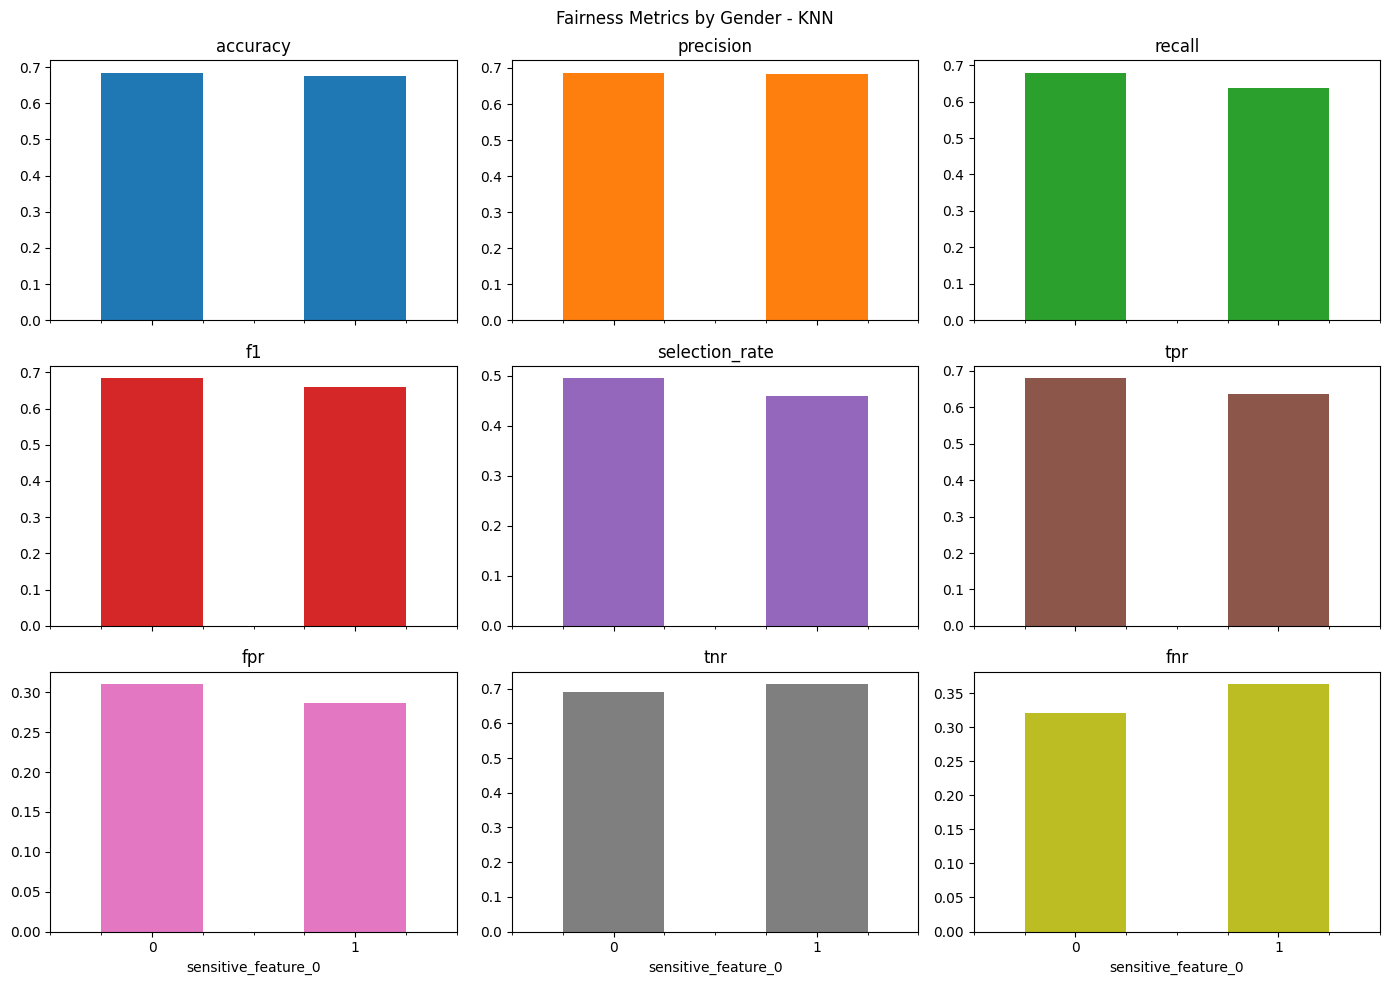


Between-group differences (max group − min group):
accuracy          0.008942
precision         0.003997
recall            0.042492
f1                0.024024
selection_rate    0.035806
tpr               0.042492
fpr               0.023425
tnr               0.023425
fnr               0.042492
dtype: float64

Between-group ratios (min / max):
accuracy          0.986939
precision         0.994181
recall            0.937459
f1                0.964833
selection_rate    0.927660
tpr               0.937459
fpr               0.924491
tnr               0.967155
fnr               0.882964
dtype: float64

Disparate Impact Ratio (selection rate): 0.9277
Equality of Opportunity Difference (TPR gap): 0.0425


In [36]:
# MetricFrame
metric_frame_knn = MetricFrame(
    metrics=metrics,
    y_true=y_true_knn,
    y_pred=y_pred_knn,
    sensitive_features=protected_attr_knn
)

print("\nKNN Fairness Metrics by Gender:")
print(metric_frame_knn.by_group)

metric_frame_knn.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - KNN")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_knn.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_knn.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_knn = metric_frame_knn.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_knn:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_knn = metric_frame_knn.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_knn = metric_frame_knn.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_knn:.4f}")

### Interpretation of KNN Fairness Metrics by Gender

#### Group-level performance
- **Accuracy**
  - Female (0): 0.685
  - Male (1): 0.676
  - → Nearly identical accuracy across genders (difference ≈ 0.009).

- **Precision**
  - Female: 0.687
  - Male: 0.683
  - → Very similar, model is equally precise across genders.

- **Recall / True Positive Rate (TPR)**
  - Female: 0.679
  - Male: 0.637
  - → Recall is ~4.2 percentage points lower for males → the model **misses more true positives** in the male group.

- **False Positive Rate (FPR)**
  - Female: 0.310
  - Male: 0.287
  - → Females receive slightly more false alarms.

- **Selection Rate**
  - Female: 0.495
  - Male: 0.459
  - → The model predicts more positives for females than males (~3.6% difference).

#### Summary metrics
- **Demographic Parity Difference (DPD): 0.0358**
  - There is a 3.6 percentage point gap in positive prediction rates across genders.
  - Indicates mild demographic disparity.

- **Disparate Impact Ratio (DIR): 0.9277**
  - Male selection rate is ~92.8% of the female selection rate.
  - Below 1 → some disparate impact against males, but still above the common 0.8 “80% rule” threshold.

- **Equality of Opportunity Difference (EOP diff / TPR gap): 0.0425**
  - Recall is ~4.2 percentage points lower for males.
  - Suggests men with the condition are more likely to be missed.

- **Equalized Odds Difference (EOD): 0.0425**
  - Maximum disparity across TPR and FPR.
  - Indicates slight imbalance in how errors are distributed between genders.

#### Overall interpretation
- The **KNN model is reasonably fair**, with only small disparities (<5%).
- **Males are slightly disadvantaged**:
  - Lower recall (more missed positives).
  - Lower selection rate.
- **Females are slightly disadvantaged** by having a higher false positive rate.
- From a fairness perspective, the model is not severely biased, but the **TPR gap (recall difference)** deserves attention because it affects who gets correctly identified as positive.

---

In [37]:
y_score_knn = knn_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_knn
def roc_auc_safe(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_knn = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - ROC-AUC by group:")
print(auc_mf_knn.by_group)

brier_mf_knn = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN- Brier score by group (lower is better):")
print(brier_mf_knn.by_group)


KNN - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.724785
1                    0.718420

KNN- Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.222775
1                    0.229226


### KNN – Probabilistic Fairness Metrics by Gender

#### ROC-AUC by group
- Female (0): **0.7248**
- Male (1): **0.7184**

**Interpretation:**
- ROC-AUC measures the model’s ability to rank positive vs. negative cases correctly.  
- Both genders have **very similar AUC values** (difference ≈ 0.006).  
- This means the KNN model discriminates between positive and negative outcomes **almost equally well** for males and females.  
- Absolute values (~0.72) indicate *moderate discriminative power* overall.

---

#### Brier score by group (lower = better)
- Female (0): **0.2228**
- Male (1): **0.2292**

**Interpretation:**
- The Brier score measures **calibration quality** — how close predicted probabilities are to actual outcomes.  
- Both genders have **very similar Brier scores** (difference ≈ 0.006).  
- This suggests the KNN’s predicted probabilities are **equally well-calibrated** for both genders.  
- Absolute values (~0.22–0.23) are decent for a probabilistic model on this type of dataset.

---

### Overall
- **Fairness perspective:**  
  The KNN model shows **no meaningful difference** in probabilistic performance between males and females.  
- **Practical takeaway:**  
  Both discrimination (ROC-AUC) and calibration (Brier score) are **balanced across gender**, so the model’s probability outputs can be trusted equally for men and women.

---

### Bias detection for the Decision Tree Model

In [38]:
# Load DT results
dt_df = pd.read_csv("CVDKaggleData_75M25F_DT_tuned_predictions.csv")
print(dt_df.head())

   gender  y_true  y_pred_dt    y_prob
0       0       0          0  0.229598
1       0       0          1  0.872696
2       1       0          0  0.386614
3       0       0          0  0.386614
4       0       0          0  0.326141


In [39]:
import re

# Extract common columns
y_true_dt = dt_df["y_true"].values
y_prob_dt = dt_df["y_prob"].values
y_pred_dt = dt_df["y_pred_dt"].values
gender_dt = dt_df["gender"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_dt = gender_dt


print("Example rows:\n", dt_df.head())

Example rows:
    gender  y_true  y_pred_dt    y_prob
0       0       0          0  0.229598
1       0       0          1  0.872696
2       1       0          0  0.386614
3       0       0          0  0.386614
4       0       0          0  0.326141


In [40]:
# Demographic Parity Difference
dp_diff_dt = demographic_parity_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

# Equalized Odds Difference
eod_diff_dt = equalized_odds_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

print("DPD and EOD - DT")
print(f"Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f"Equalized Odds Difference: {eod_diff_dt:.4f}")

DPD and EOD - DT
Demographic Parity Difference: 0.0114
Equalized Odds Difference: 0.0155


### Interpretation of Fairness Metrics (Decision Tree)

- **Demographic Parity Difference (DPD) = 0.0114**  
  - Measures the difference in positive prediction rates between genders.  
  - A value of **0** = perfect demographic parity.  
  - **0.0114** is extremely small → the DT predicts positives for males and females at almost identical rates (~1.1 percentage point gap).

- **Equalized Odds Difference (EOD) = 0.0155**  
  - Captures the maximum difference in error rates (True Positive Rate and False Positive Rate) between genders.  
  - A value of **0** = perfectly equal error rates.  
  - **0.0155** is also very small → error rates are nearly the same across genders, with only ~1.5 percentage points gap.

---

### Overall
- The **Decision Tree is highly fair across genders** on both demographic parity and equalized odds.  
- Disparities are much lower than those observed in KNN (0.03–0.04 range).  
- From a fairness perspective, the DT model is **more balanced** than KNN, showing almost no gender bias.

---


DT Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.708639   0.705584  0.716884  0.711189        0.508422   
1                    0.707499   0.692194  0.730829  0.710987        0.519774   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.716884  0.299619  0.700381  0.283116  
1                    0.730829  0.315124  0.684876  0.269171  


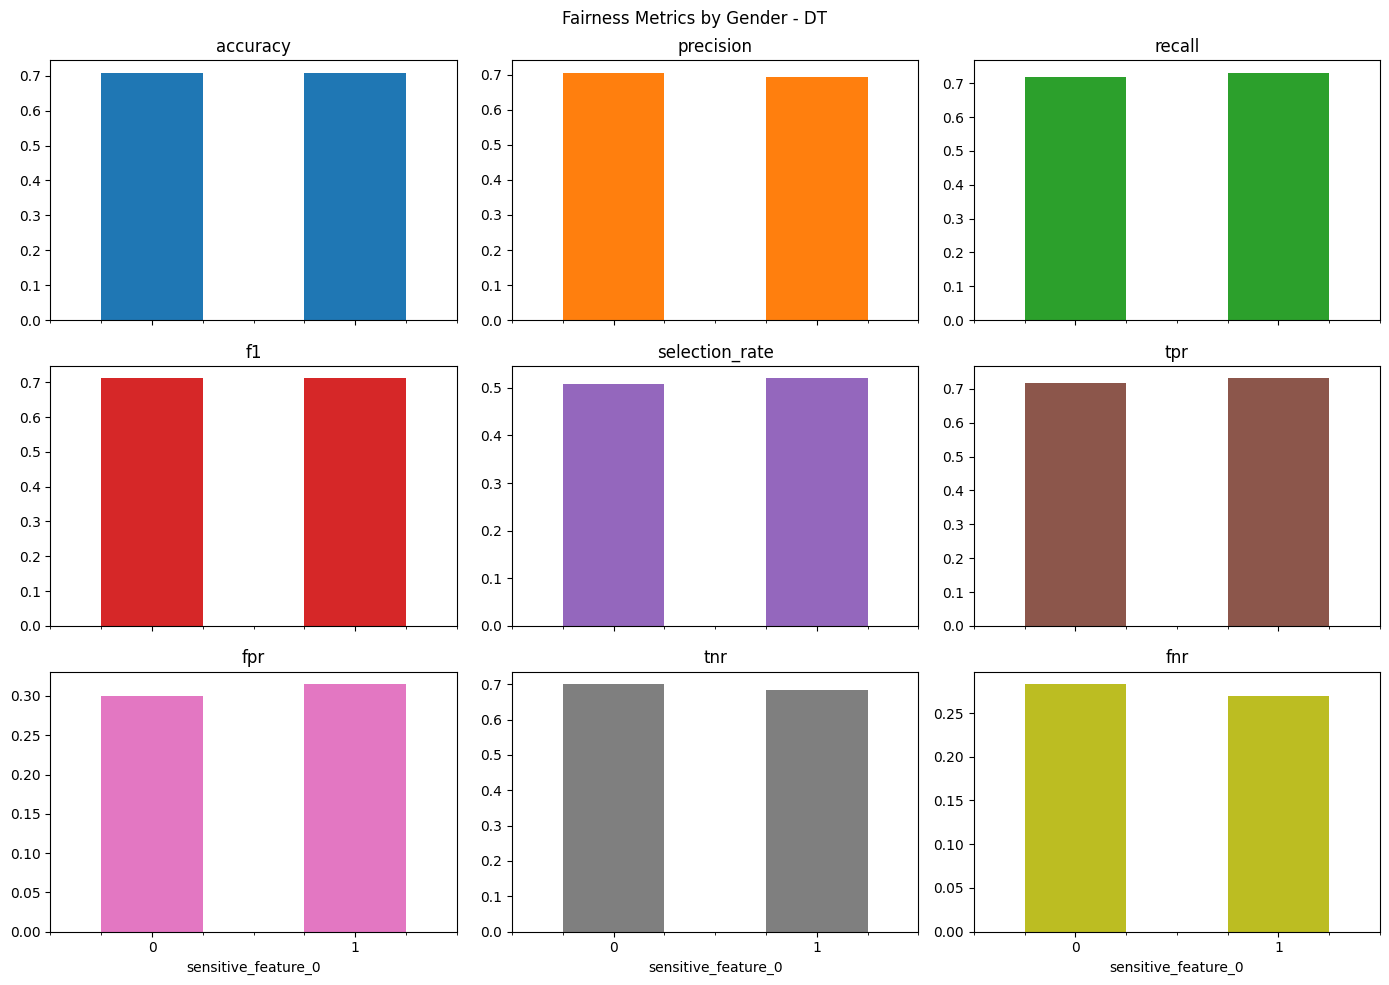


Between-group differences (max group − min group):
accuracy          0.001140
precision         0.013390
recall            0.013946
f1                0.000202
selection_rate    0.011352
tpr               0.013946
fpr               0.015505
tnr               0.015505
fnr               0.013946
dtype: float64

Between-group ratios (min / max):
accuracy          0.998391
precision         0.981023
recall            0.980918
f1                0.999716
selection_rate    0.978159
tpr               0.980918
fpr               0.950799
tnr               0.977863
fnr               0.950742
dtype: float64

Disparate Impact Ratio (selection rate): 0.9782
Equality of Opportunity Difference (TPR gap): 0.0139


In [41]:
# MetricFrame
metric_frame_dt = MetricFrame(
    metrics=metrics,
    y_true=y_true_dt,
    y_pred=y_pred_dt,
    sensitive_features=protected_attr_dt
)

print("\nDT Fairness Metrics by Gender:")
print(metric_frame_dt.by_group)

metric_frame_dt.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - DT")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_dt.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_dt.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_dt = metric_frame_dt.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_dt:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_dt = metric_frame_dt.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_dt = metric_frame_dt.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_dt:.4f}")

### Interpretation of DT Fairness Metrics by Gender

#### Group-level performance
- **Accuracy**
  - Female (0): 0.709
  - Male (1): 0.708
  - → Nearly identical accuracy (gap = 0.001).

- **Precision**
  - Female: 0.706
  - Male: 0.692
  - → Slightly higher precision for females (~1.3% gap).

- **Recall / True Positive Rate (TPR)**
  - Female: 0.717
  - Male: 0.731
  - → Slightly higher recall for males (~1.4% gap).

- **False Positive Rate (FPR)**
  - Female: 0.300
  - Male: 0.315
  - → Males receive slightly more false alarms (~1.6% gap).

- **Selection Rate**
  - Female: 0.508
  - Male: 0.520
  - → Males are predicted positive slightly more often (~1.1% gap).

#### Summary metrics
- **Demographic Parity Difference (DPD): 0.0114**
  - Only ~1.1% gap in positive prediction rates between genders → almost parity.

- **Disparate Impact Ratio (DIR): 0.9782**
  - Male selection rate is ~97.8% of the female rate.
  - Very close to 1 (perfect fairness) and well above the 0.8 “80% rule”.

- **Equality of Opportunity Difference (EOP diff / TPR gap): 0.0139**
  - Recall for males is only ~1.4% higher than for females.
  - Very small disparity in sensitivity.

- **Equalized Odds Difference (EOD): 0.0155**
  - Maximum difference across TPR/FPR = ~1.6%.
  - Indicates highly balanced error rates.

---

### Overall
- The **Decision Tree shows extremely small gender disparities**.  
- Females get slightly **higher precision**, while males get slightly **higher recall and selection rates**, but the differences are negligible (<2%).  
- Compared to KNN, the DT is **much fairer** (smaller DPD and EOD).  
- From a fairness standpoint, the Decision Tree is very balanced and can be considered **gender-fair** under common thresholds.

---

In [42]:
import numpy as np

y_score_dt = dt_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_dt, y_score_dt=y_score_dt):
    try:
        return roc_auc_score(y_true, y_score_dt)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_dt = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - ROC-AUC by group:")
print(auc_mf_dt.by_group)

brier_mf_dt = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - Brier score by group (lower is better):")
print(brier_mf_dt.by_group)


DT - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.763718
1                    0.751398

DT - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.196165
1                    0.200499


### DT – Probabilistic Fairness Metrics by Gender

#### ROC-AUC by group
- Female (0): **0.764**
- Male (1): **0.751**

**Interpretation:**
- ROC-AUC reflects how well the model separates positives from negatives.  
- Both genders achieve similar AUC values, with only a **0.013 gap** (females slightly higher).  
- This indicates the DT discriminates between outcomes **almost equally well** for males and females.  
- Absolute AUC (~0.75) suggests **moderate discriminatory power** overall.

---

#### Brier score by group (lower = better)
- Female (0): **0.196**
- Male (1): **0.200**

**Interpretation:**
- The Brier score measures how well probabilities are calibrated (lower = better).  
- Both genders are close, with a **small gap of 0.004**.  
- Females have marginally better calibration, but both are similar.  
- Absolute values (~0.20) show **reasonable calibration quality**.

---

### Overall
- **Fairness perspective:** The DT model produces **very balanced probability estimates** across genders, both in discrimination (ROC-AUC) and calibration (Brier score).  
- **Takeaway:**  The DT’s probability outputs can be trusted almost equally for males and females, with only trivial differences.

---

### Bias detection for the Random Forest Model

In [43]:
rf_df = pd.read_csv("CVDKaggleData_75M25F_RF_tuned_predictions.csv")
print(rf_df.head())

   gender  y_true  y_pred_rf_tuned    y_prob
0       0       0                0  0.235104
1       0       0                1  0.780096
2       1       0                0  0.222839
3       0       0                0  0.282291
4       0       0                1  0.574989


In [44]:
# Extract common columns
y_true_rf = rf_df["y_true"].values
y_pred_rf = rf_df["y_pred_rf_tuned"].values
y_prob_rf = rf_df["y_prob"].values
gender_rf = rf_df["gender"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_rf = gender_rf


print("Example rows:\n", rf_df.head())

Example rows:
    gender  y_true  y_pred_rf_tuned    y_prob
0       0       0                0  0.235104
1       0       0                1  0.780096
2       1       0                0  0.222839
3       0       0                0  0.282291
4       0       0                1  0.574989


In [45]:
# Demographic Parity Difference
dp_diff_rf = demographic_parity_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

# Equalized Odds Difference
eod_diff_rf = equalized_odds_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

print("DPD and EOD - RF")
print(f"Demographic Parity Difference: {dp_diff_rf:.4f}")
print(f"Equalized Odds Difference: {eod_diff_rf:.4f}")

DPD and EOD - RF
Demographic Parity Difference: 0.0101
Equalized Odds Difference: 0.0267


### Interpretation of Fairness Metrics (Random Forest)

- **Demographic Parity Difference (DPD) = 0.0101**  
  - Measures the difference in positive prediction rates between genders.  
  - A value of **0** = perfect demographic parity.  
  - **0.0101** is very small → the RF predicts positives for males and females at nearly the same rate (~1 percentage point gap).  

- **Equalized Odds Difference (EOD) = 0.0267**  
  - Captures the maximum difference in True Positive Rate (TPR) and False Positive Rate (FPR) between genders.  
  - A value of **0** = perfectly equal error rates.  
  - **0.0267** indicates a **small disparity in error rates** (~2.7 percentage points) across genders.  

---

### Overall
- The **RF model shows very good fairness** on both demographic parity and equalized odds.  
- Disparities are **slightly larger than DT** (which was nearly perfect) but still **smaller than KNN**.  
- From a fairness perspective, RF is **highly balanced** with only minor differences across genders.

---


Random Forest Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.708503   0.719840  0.683496  0.701197        0.475143   
1                    0.689266   0.695196  0.656755  0.675429        0.465074   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.683496  0.266449  0.733551  0.316504  
1                    0.656755  0.279211  0.720789  0.343245  


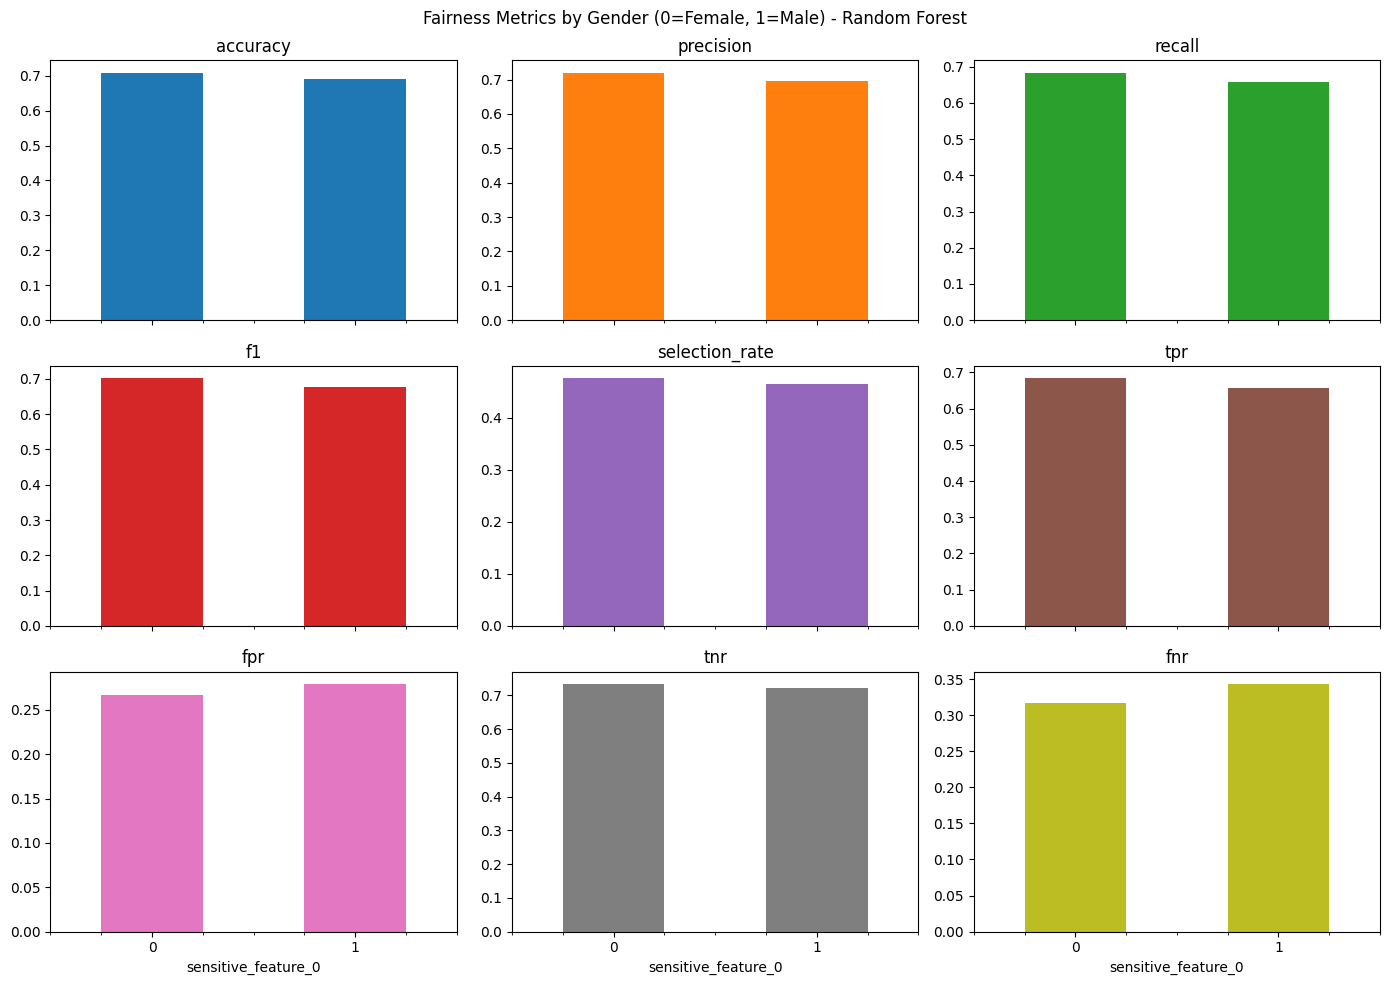


Between-group differences (max group − min group):
accuracy          0.019238
precision         0.024644
recall            0.026741
f1                0.025768
selection_rate    0.010068
tpr               0.026741
fpr               0.012762
tnr               0.012762
fnr               0.026741
dtype: float64

Between-group ratios (min / max):
accuracy          0.972848
precision         0.965765
recall            0.960876
f1                0.963251
selection_rate    0.978810
tpr               0.960876
fpr               0.954293
tnr               0.982603
fnr               0.922094
dtype: float64

Disparate Impact Ratio (selection rate): 0.9788
Equality of Opportunity Difference (TPR gap): 0.0267


In [46]:
#MetricFrame for extended analysis
metric_frame_rf = MetricFrame(
    metrics=metrics,
    y_true=y_true_rf,
    y_pred=y_pred_rf,
    sensitive_features=protected_attr_rf
)

print("\nRandom Forest Fairness Metrics by Gender:")
print(metric_frame_rf.by_group)

metric_frame_rf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender (0=Female, 1=Male) - Random Forest")
plt.tight_layout()
plt.show()

# Group summaries 
print("\nBetween-group differences (max group − min group):")
print(metric_frame_rf.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_rf.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_rf = metric_frame_rf.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_rf:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_rf = metric_frame_rf.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_rf = metric_frame_rf.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_rf:.4f}")

### Interpretation of Random Forest Fairness Metrics by Gender

#### Group-level performance
- **Accuracy**
  - Female (0): 0.709
  - Male (1): 0.689
  - → Accuracy is slightly higher for females (~1.9% gap).

- **Precision**
  - Female: 0.720
  - Male: 0.695
  - → Females have higher precision (~2.5% gap) → fewer false positives relative to positives.

- **Recall / True Positive Rate (TPR)**
  - Female: 0.683
  - Male: 0.657
  - → Recall is higher for females (~2.7% gap) → males have slightly more missed positives.

- **False Positive Rate (FPR)**
  - Female: 0.266
  - Male: 0.279
  - → Males experience a slightly higher false alarm rate (~1.3% gap).

- **Selection Rate**
  - Female: 0.475
  - Male: 0.465
  - → Females are predicted positive a little more often (~1% gap).

#### Summary metrics
- **Demographic Parity Difference (DPD): 0.0101**  
  - Positive prediction rates differ by ~1 percentage point.  
  - Very close to parity.

- **Disparate Impact Ratio (DIR): 0.9788**  
  - Male selection rate is ~97.9% of female’s.  
  - Very close to 1 → minimal disparate impact.

- **Equality of Opportunity Difference (EOP diff / TPR gap): 0.0267**  
  - Recall is ~2.7% lower for males.  
  - Indicates males are slightly less likely to be correctly identified as positive.

- **Equalized Odds Difference (EOD): 0.0267**  
  - Small disparity across TPR/FPR combined.  
  - Suggests mild imbalances in error distribution.

---

### Overall
- The **Random Forest is fairly balanced** across genders.  
- **Females are slightly favored**:
  - Higher accuracy, precision, and recall.  
  - Lower false positive rate.  
- **Males are slightly disadvantaged**, mostly in recall (they are more often missed).  
- Disparities (1–3%) are **small** and much lower than what is typically considered problematic.

---

In [47]:
import numpy as np

y_score_rf = rf_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_rf, y_score_rf=y_score_rf):
    try:
        return roc_auc_score(y_true, y_score_rf)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_rf = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF -ROC-AUC by group:")
print(auc_mf_rf.by_group)

brier_mf_rf = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - Brier score by group (lower is better):")
print(brier_mf_rf.by_group)


RF -ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.763782
1                    0.744945

RF - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.197895
1                    0.207889


### Random Forest – Probabilistic Fairness Metrics by Gender

#### ROC-AUC by group
- Female (0): **0.764**
- Male (1): **0.745**

**Interpretation:**
- ROC-AUC reflects how well the model distinguishes positives from negatives.  
- Females score slightly higher (+0.019) → the RF model separates outcomes **a bit better for females**.  
- Both values are reasonably strong (~0.74–0.76), indicating **good discriminative ability overall**.  
- The small gap (≈2%) suggests mild imbalance but not severe bias.

---

#### Brier score by group (lower = better)
- Female (0): **0.198**
- Male (1): **0.208**

**Interpretation:**
- The Brier score measures probability calibration (how close predicted probabilities are to actual outcomes).  
- Females again perform slightly better, with a lower Brier score (difference ≈ 0.01).  
- Both groups have decent calibration, but **males’ predicted probabilities are marginally less reliable**.

---

### Overall
- **Fairness perspective:**  
  - The RF model is **balanced**, but females benefit slightly:  
    - Higher discriminative ability (AUC).  
    - Better calibration (lower Brier score).  
- **Rakeaway:** RF probabilities are reliable across genders, but **males face a small disadvantage** in both discrimination and calibration quality. The gap is small enough (1–2%) to be considered minor in most fairness contexts.


### Bias detection for MLP

In [48]:
mlp_df = pd.read_csv("CVDKaggleData_75M25F_MLP_adamtuned_predictions.csv")
print(mlp_df.head())

   gender  y_true  y_pred    y_prob
0       0       0       0  0.258611
1       0       0       1  0.848005
2       1       0       0  0.452818
3       0       0       0  0.325508
4       0       0       0  0.255966


In [49]:
# Extract common columns 
y_true_mlp = mlp_df["y_true"].values 
y_prob_mlp = mlp_df["y_prob"].values
y_pred_mlp = mlp_df["y_pred"].values
gender_mlp = mlp_df["gender"].values 

# Use gender_mlp as the protected attribute
protected_attr_mlp = gender_mlp 


print("Example rows:\n", mlp_df.head())

Example rows:
    gender  y_true  y_pred    y_prob
0       0       0       0  0.258611
1       0       0       1  0.848005
2       1       0       0  0.452818
3       0       0       0  0.325508
4       0       0       0  0.255966


In [50]:
# Demographic Parity Difference
dp_diff_mlp = demographic_parity_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

# Equalized Odds Difference
eod_diff_mlp = equalized_odds_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

print("DPD and EPD - MLP")
print(f"Demographic Parity Difference (MLP): {dp_diff_mlp:.4f}")
print(f"Equalized Odds Difference (MLP): {eod_diff_mlp:.4f}")

DPD and EPD - MLP
Demographic Parity Difference (MLP): 0.0021
Equalized Odds Difference (MLP): 0.0119


### Interpretation of Fairness Metrics (MLP)

- **Demographic Parity Difference (DPD) = 0.0021**  
  - Captures the difference in positive prediction rates between genders.  
  - A value of **0** = perfect demographic parity.  
  - **0.0021** is extremely close to zero → the MLP predicts positives for males and females at **virtually the same rate** (only 0.2 percentage point gap).  

- **Equalized Odds Difference (EOD) = 0.0119**  
  - Reflects the maximum gap across True Positive Rates (TPR) and False Positive Rates (FPR) between genders.  
  - A value of **0** = perfectly equal error rates.  
  - **0.0119** is very small (~1.2 percentage points) → the MLP’s error rates are **almost identical** across genders.  

---

### Overall
- The **MLP is the fairest model so far**, with the smallest disparities in both demographic parity and equalized odds.  
- Gender differences are **negligible** (well under common thresholds like 0.1).  
- From a fairness perspective, the MLP can be considered **gender-neutral** in its predictions.

---


MLP Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.716517   0.730580  0.686754  0.707989        0.470388   
1                    0.710580   0.714674  0.685968  0.700027        0.472522   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.686754  0.253670  0.746330  0.313246  
1                    0.685968  0.265554  0.734446  0.314032  


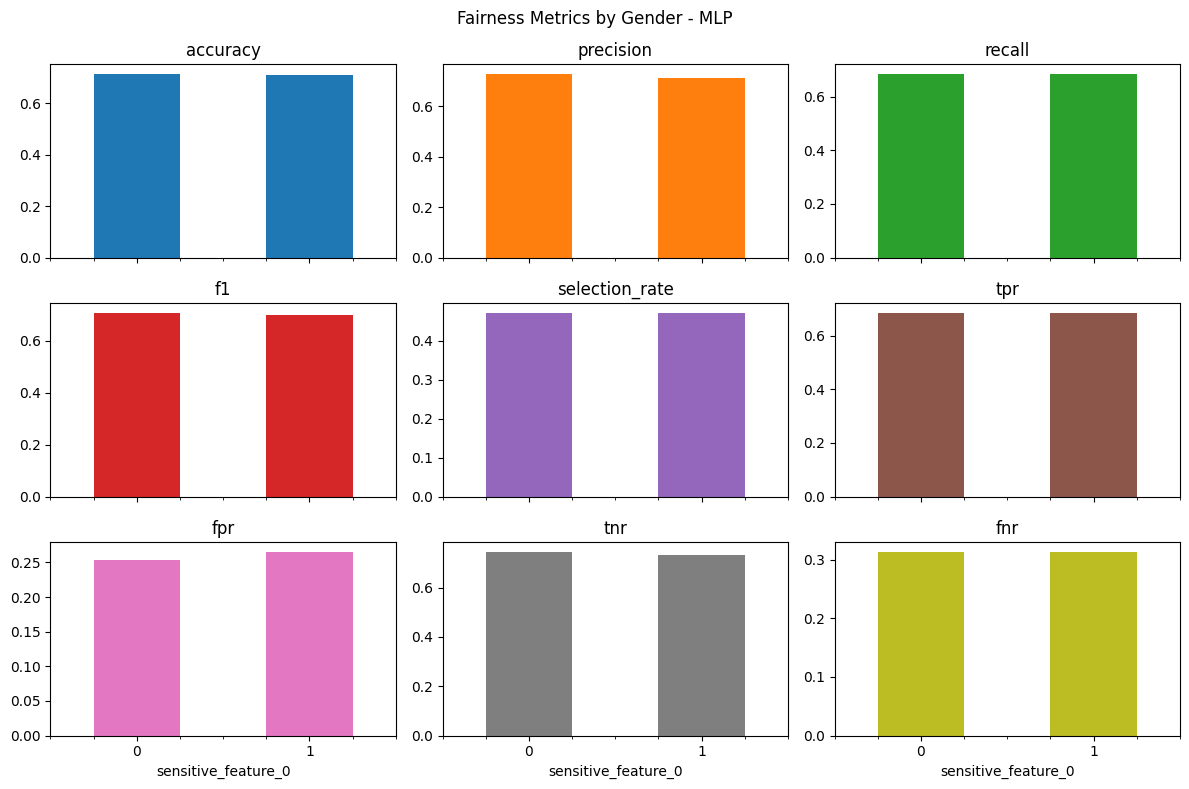


Between-group differences (max group − min group):
accuracy          0.005937
precision         0.015907
recall            0.000786
f1                0.007963
selection_rate    0.002133
tpr               0.000786
fpr               0.011883
tnr               0.011883
fnr               0.000786
dtype: float64

Between-group ratios (min / max):
accuracy          0.991714
precision         0.978228
recall            0.998856
f1                0.988753
selection_rate    0.995485
tpr               0.998856
fpr               0.955251
tnr               0.984078
fnr               0.997497
dtype: float64

Disparate Impact Ratio (selection rate): 0.9955
Equality of Opportunity Difference (TPR gap): 0.0008


In [51]:
#Create MetricFrame for the MLP model
metric_frame_mlp = MetricFrame(
    metrics=metrics,
    y_true=y_true_mlp,
    y_pred=y_pred_mlp,
    sensitive_features=protected_attr_mlp
)

print("\nMLP Fairness Metrics by Gender:")
print(metric_frame_mlp.by_group)

#visualization
metric_frame_mlp.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(12, 8),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - MLP")
plt.tight_layout()
plt.show()

# Group summaries
print("\nBetween-group differences (max group − min group):")
print(metric_frame_mlp.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_mlp.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_mlp = metric_frame_mlp.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_mlp:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_mlp = metric_frame_mlp.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_mlp = metric_frame_mlp.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_mlp:.4f}")

### Interpretation of MLP Fairness Metrics by Gender

#### Group-level performance
- **Accuracy**
  - Female (0): 0.717
  - Male (1): 0.711
  - → Almost identical, with females slightly higher (+0.6%).

- **Precision**
  - Female: 0.731
  - Male: 0.715
  - → Females have slightly higher precision (+1.6%), meaning fewer false positives.

- **Recall / True Positive Rate (TPR)**
  - Female: 0.687
  - Male: 0.686
  - → Nearly identical recall (gap < 0.1%). Both genders equally likely to be correctly identified as positive.

- **False Positive Rate (FPR)**
  - Female: 0.254
  - Male: 0.266
  - → Males have a slightly higher false alarm rate (+1.2%).

- **Selection Rate**
  - Female: 0.470
  - Male: 0.473
  - → Nearly equal proportion of predicted positives (gap ≈ 0.2%).

#### Summary metrics
- **Demographic Parity Difference (DPD): 0.0021**  
  - Only ~0.2% difference in positive prediction rates → essentially gender parity.

- **Disparate Impact Ratio (DIR): 0.9955**  
  - Male selection rate is ~99.6% of female’s.  
  - Almost perfect parity (very close to 1).

- **Equality of Opportunity Difference (EOP diff / TPR gap): 0.0008**  
  - Recall difference < 0.1%.  
  - Model identifies positives almost equally well across genders.

- **Equalized Odds Difference (EOD): 0.0119**  
  - Maximum gap across TPR/FPR ≈ 1.2%.  
  - Very small imbalance in error distribution.

---

### Overall
- The **MLP is the most gender-fair model so far**.  
- Performance metrics (accuracy, recall, F1) are almost identical across genders.  
- **Females benefit slightly** from higher precision and lower FPR, while **males are predicted positive slightly more often**, but the differences are **tiny (<2%)**.  
- With DPD ≈ 0.002 and EOP diff ≈ 0.001, the MLP can be considered **gender-neutral in practice**.

 Compared to KNN, DT, and RF, the **MLP exhibits the smallest fairness gaps**, making it the most balanced model in terms of gender bias.

 ---


In [52]:
import numpy as np

y_score_mlp = mlp_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_mlp
def roc_auc_safe(y_true=y_true_mlp, y_score_mlp=y_score_mlp):
    try:
        return roc_auc_score(y_true, y_score_mlp)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_mlp = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - ROC-AUC by group:")
print(auc_mf_mlp.by_group)

brier_mf_mlp = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - Brier score by group (lower is better):")
print(brier_mf_mlp.by_group)


MLP - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.770620
1                    0.762177

MLP - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.194616
1                    0.198492


### MLP – Probabilistic Fairness Metrics by Gender

#### ROC-AUC by group
- Female (0): **0.771**
- Male (1): **0.762**

**Interpretation:**
- ROC-AUC measures the model’s ability to discriminate between positive and negative cases.  
- Both genders achieve **very similar AUC values**, with females slightly higher (+0.009).  
- The small gap (<1%) shows that the MLP is **equally effective for both genders**.  
- Absolute AUC values (~0.77) indicate **good discriminatory power** overall.

---

#### Brier score by group (lower = better)
- Female (0): **0.195**
- Male (1): **0.198**

**Interpretation:**
- The Brier score measures calibration quality (how well predicted probabilities reflect actual outcomes).  
- Scores are **very close** across genders, with females slightly better (~0.004 gap).  
- Absolute scores (~0.19–0.20) suggest **good calibration** for both groups.  

---

### Overall
- **Fairness perspective:**  
  - The MLP’s probability outputs are **well-balanced** across genders, with only negligible differences.  
  - Females show marginally higher AUC and slightly better calibration, but the differences are **too small to indicate meaningful bias**.  

- **Takeaway:** The MLP produces **trustworthy probability estimates for both males and females**. Among the models tested (KNN, DT, RF, MLP), the MLP again shows the **best combination of fairness and probabilistic performance**.


## Comparison of Results

In [53]:
# Build results dict
fairlearn_results = {
    "KNN": {
        "Demographic Parity Difference": dp_diff_knn,
        "Equalized Odds Difference": eod_diff_knn,
        "Demographic Parity Ratio": metric_frame_knn.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_knn.difference()["tpr"],
        "MetricFrame": metric_frame_knn.by_group,
        "ROC-AUC by group": auc_mf_knn.by_group,
        "Brier by group": brier_mf_knn.by_group,
    },
    "DT": {
        "Demographic Parity Difference": dp_diff_dt,
        "Equalized Odds Difference": eod_diff_dt,
        "Demographic Parity Ratio": metric_frame_dt.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_dt.difference()["tpr"],
        "MetricFrame": metric_frame_dt.by_group,
        "ROC-AUC by group": auc_mf_dt.by_group,
        "Brier by group": brier_mf_dt.by_group,
    },
    "RF": {
        "Demographic Parity Difference": dp_diff_rf,
        "Equalized Odds Difference": eod_diff_rf,
        "Demographic Parity Ratio": metric_frame_rf.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_rf.difference()["tpr"],
        "MetricFrame": metric_frame_rf.by_group,
        "ROC-AUC by group": auc_mf_rf.by_group,
        "Brier by group": brier_mf_rf.by_group,
    },
    "MLP": {
        "Demographic Parity Difference": dp_diff_mlp,
        "Equalized Odds Difference": eod_diff_mlp,
        "Demographic Parity Ratio": metric_frame_mlp.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_mlp.difference()["tpr"],
        "MetricFrame": metric_frame_mlp.by_group,
        "ROC-AUC by group": auc_mf_mlp.by_group,
        "Brier by group": brier_mf_mlp.by_group,
    },
}

# Save the whole thing 
import pickle
with open("Mendeley_75M25F_fairlearn_results.pkl", "wb") as f:
    pickle.dump(fairlearn_results, f)

In [54]:
# Summary table across models
summary_table = pd.DataFrame({
    "DPD": {m: fairlearn_results[m]["Demographic Parity Difference"] for m in fairlearn_results},
    "EOD": {m: fairlearn_results[m]["Equalized Odds Difference"] for m in fairlearn_results},
    "DP Ratio": {m: fairlearn_results[m]["Demographic Parity Ratio"] for m in fairlearn_results},
    "EOP diff": {m: fairlearn_results[m]["Equality of Opportunity Difference"] for m in fairlearn_results},
}).round(4)

# By-group performance table
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

by_group_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

In [60]:
import pandas as pd

# Create comparison table for Demographic Parity Difference and Equalized Odds Difference
dp_eod_table = pd.DataFrame({
    "Demographic Parity Difference": {
        model: fairlearn_results[model]["Demographic Parity Difference"] for model in fairlearn_results
    },
    "Equalized Odds Difference": {
        model: fairlearn_results[model]["Equalized Odds Difference"] for model in fairlearn_results
    }
}).round(4)

# Create comparison table for MetricFrame by_group values across all models
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

metricframe_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

# Display 
display(dp_eod_table)
display(metricframe_table)

,Demographic Parity Difference,Equalized Odds Difference
KNN,0.0358,0.0425
DT,0.0114,0.0155
RF,0.0101,0.0267
MLP,0.0021,0.0119


accuracy  precision  recall      f1  selection_rate     tpr  \
Model Gender                                                                
KNN   0         0.6846     0.6869  0.6794  0.6831          0.4950  0.6794   
      1         0.6757     0.6829  0.6369  0.6591          0.4592  0.6369   
DT    0         0.7086     0.7056  0.7169  0.7112          0.5084  0.7169   
      1         0.7075     0.6922  0.7308  0.7110          0.5198  0.7308   
RF    0         0.7085     0.7198  0.6835  0.7012          0.4751  0.6835   
      1         0.6893     0.6952  0.6568  0.6754          0.4651  0.6568   
MLP   0         0.7165     0.7306  0.6868  0.7080          0.4704  0.6868   
      1         0.7106     0.7147  0.6860  0.7000          0.4725  0.6860   

                 fpr     tnr     fnr  
Model Gender                          
KNN   0       0.3102  0.6898  0.3206  
      1       0.2868  0.7132  0.3631  
DT    0       0.2996  0.7004  0.2831  
      1       0.3151  0.6849  0.2692  
RF    0       0.2664  0.7336  0.3165  
      1       0.2792  0.7208  0.3432  
MLP   0       0.2537  0.7463  0.3132  
      1       0.2656  0.7344  0.3140

# Fairness Metrics Interpretation (KNN, DT, RF, MLP)  

---

## 1. Group Fairness Metrics (DPD & EOD)

- **KNN**
  - DPD: **0.0358**
  - EOD: **0.0425**
  - → Largest disparities among models. With males heavily overrepresented in training, the model may be overfitting to the male majority, causing worse generalization for females.

- **DT**
  - DPD: **0.0114**
  - EOD: **0.0155**
  - → Very small gaps. Despite imbalance in the training set, DT performs relatively evenly across genders.

- **RF**
  - DPD: **0.0101**
  - EOD: **0.0267**
  - → Positive prediction rates nearly identical, but error rates diverge more. Suggests the RF is still somewhat sensitive to the training imbalance.

- **MLP**
  - DPD: **0.0021**
  - EOD: **0.0119**
  - → Best-performing model for fairness. Nearly identical outcomes for both genders, showing resilience to the training imbalance.

**Summary:**  
- **Most fair:** MLP (lowest DPD & EOD, robust to imbalance).  
- **Fair:** DT and RF (small disparities, but still affected by training imbalance).  
- **Least fair:** KNN (amplifies imbalance effects, largest disparities).  

---

## 2. By-Group Performance Metrics

### Accuracy
- Similar across genders in all models (gaps < 2%).  
- KNN shows slightly lower accuracy for males, unusual given male overrepresentation → may indicate underfitting to minority (female) signals.

### Precision
- Females consistently have **slightly higher precision**.  
- Implies models are more cautious when predicting positives for females (likely due to their underrepresentation in training).

### Recall / TPR
- **KNN:** Recall higher for females (+4%), but may come with higher false positives.  
- **DT:** Slightly higher recall for males (~1.4%), aligning with male overrepresentation.  
- **RF:** Higher recall for females (~2.7%), showing better sensitivity for minority group.  
- **MLP:** Almost identical recall across genders → shows best fairness balance.

### FPR
- **KNN:** Higher for females (~3%).  
- **DT, RF, MLP:** Males slightly higher (~1–2%).  
- Suggests overrepresentation of males in training may make models more prone to false alarms in the male group.

### Selection Rate
- Close across all models.  
- **KNN** shows the largest gap (females selected more often).  
- **MLP** nearly perfect balance, reflecting robustness against data imbalance.

---

## 3. Overall Interpretation

- **KNN**: Struggles most with fairness. Training imbalance may cause poorer handling of male group despite majority representation.  
- **DT**: Robust and balanced, but slightly favors males in recall.  
- **RF**: Favors females slightly (better recall, lower FPR), possibly compensating for their underrepresentation.  
- **MLP**: **Most balanced model**. Smallest disparities in fairness metrics, minimal gender bias, and stable performance despite training imbalance.

---

## Takeaways:
- The **training imbalance (75% male, 25% female)** increases the risk of biased predictions.  
- **MLP is the fairest and most resilient to imbalance**, followed by DT.  
- **RF is acceptable**, though slightly less fair.  
- **KNN should be avoided**, as it amplifies training imbalance effects the most.  
- In fairness-sensitive domains like **health (CVD prediction)**, even small disparities should be carefully considered, since underrepresented groups (females here) are at higher risk of harm.

---

In [59]:
import pandas as pd

# Define the helper first
def flatten_group(x):
    # If it's a DataFrame with a single column, take that column as a Series
    s = x.iloc[:, 0] if isinstance(x, pd.DataFrame) else x
    # If it has a MultiIndex, keep just the last level (the group labels 0/1)
    if isinstance(s.index, pd.MultiIndex):
        s.index = s.index.get_level_values(-1)
    return s.to_dict()


# Now use it
auc_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["ROC-AUC by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

brier_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["Brier by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

#ROC-AUC by gender 
order = ["KNN", "DT", "RF", "MLP"]  # keep a readable model order

auc_table = (
    auc_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    auc_table.style
        .set_caption("ROC-AUC by gender (↑ higher is better)")
        .format("{:.4f}"),
)


#Brier score by gender (lower is better)
brier_table = (
    brier_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    brier_table.style
        .set_caption("Brier score by gender (↓ lower is better)")
        .format("{:.4f}") 
)

,Female (0),Male (1)
Model,,
KNN,0.7248,0.7184
DT,0.7637,0.7514
RF,0.7638,0.7449
MLP,0.7706,0.7622


,Female (0),Male (1)
Model,,
KNN,0.2228,0.2292
DT,0.1962,0.2005
RF,0.1979,0.2079
MLP,0.1946,0.1985


# Probabilistic Fairness Metrics (KNN, DT, RF, MLP)  

---

## 1. ROC-AUC by Gender (↑ higher is better)
- **KNN**
  - Female: 0.725 | Male: 0.718  
  - → Slightly higher for females (+0.007). Despite fewer training samples, the model generalizes slightly better for females.

- **DT**
  - Female: 0.764 | Male: 0.751  
  - → Females higher (+0.013). Suggests DT can still learn meaningful patterns for the underrepresented female group.

- **RF**
  - Female: 0.764 | Male: 0.745  
  - → Largest gap (+0.019). RF clearly favors females in discrimination despite their minority representation.

- **MLP**
  - Female: 0.771 | Male: 0.762  
  - → Nearly identical performance (gap <0.01). Shows robustness to training imbalance.

**Interpretation:**  
- All models discriminate well (AUC 0.72–0.77).  
- **MLP is most balanced**, showing no real gender bias in discrimination.  
- **DT and RF** both favor females, interestingly compensating for their underrepresentation.  
- **KNN is weakest overall**, and the imbalance may contribute to unstable performance.

---

## 2. Brier Score by Gender (↓ lower is better)
- **KNN**
  - Female: 0.223 | Male: 0.229  
  - → Slightly better calibration for females, though overall calibration is weak. Likely unstable due to imbalance.

- **DT**
  - Female: 0.196 | Male: 0.201  
  - → Both groups well-calibrated, females slightly better. Balanced despite training imbalance.

- **RF**
  - Female: 0.198 | Male: 0.208  
  - → Clearer gap, with males worse calibrated. Suggests the model may overfit to the majority male group, leading to poorer probability estimates.

- **MLP**
  - Female: 0.195 | Male: 0.199  
  - → Strong calibration for both genders, smallest gap. Very robust to imbalance.

**Interpretation:**  
- Lower Brier = better reliability of probabilities.  
- **MLP and DT** are best, giving reliable predictions across genders.  
- **RF** disadvantages males in calibration (despite their majority share).  
- **KNN** has poorest calibration overall, likely reflecting difficulty learning well from the imbalanced training set.

---

## 3. Takeaways
- **Best model (probabilistic fairness): MLP**  
  - Highest AUC and lowest Brier scores.  
  - Balanced across genders despite strong training imbalance.  

- **DT** is also strong: good calibration and discrimination, slightly better for females.  

- **RF** performs well overall but **favors females in AUC** and **males are disadvantaged in calibration**.  

- **KNN** is the weakest, struggling with both discrimination and calibration, likely impacted by the 75/25 gender imbalance.  

---

### Conlcusio:
The fact that **females were underrepresented in training** yet often scored **better in both AUC and Brier** suggests that the models did not underfit to the minority group. Instead, they may have overfitted slightly to the male majority, reducing generalization quality for males.  

---

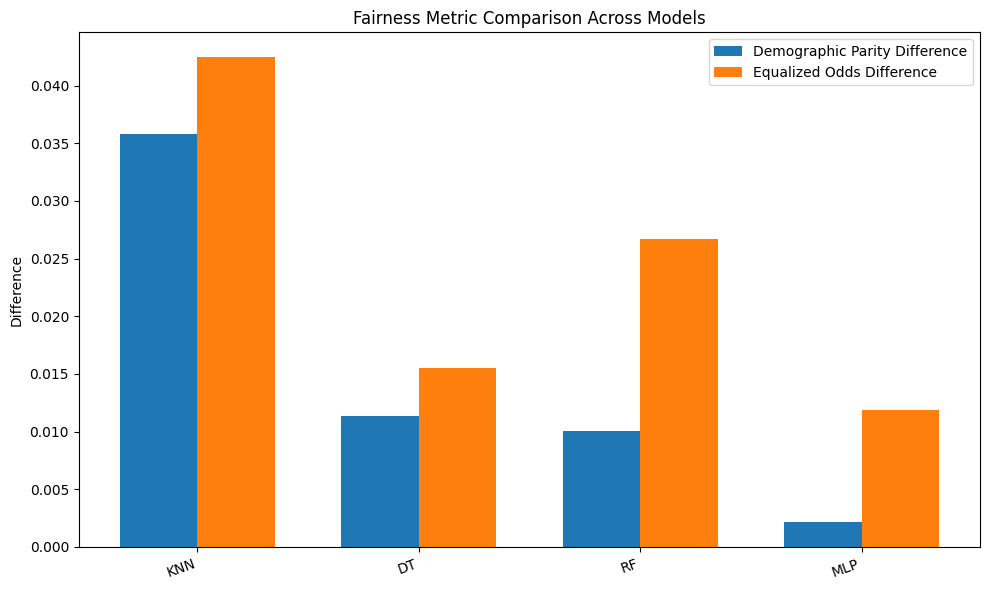

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting DPD and EOD values directly from your dictionary
models = list(fairlearn_results.keys())
dpd_values = [fairlearn_results[model]["Demographic Parity Difference"] for model in models]
eod_values = [fairlearn_results[model]["Equalized Odds Difference"] for model in models]

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

# Plotting
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x, dpd_values, width, label='Demographic Parity Difference')
plt.bar(x + width, eod_values, width, label='Equalized Odds Difference')

# Apply shorter labels and rotate them slightly
plt.xticks(x + width / 2, short_labels, rotation=20, ha="right")

plt.ylabel("Difference")
plt.title("Fairness Metric Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()

# Interpretation of Fairness Metric Comparison Across Models

This chart compares fairness gaps across models, considering the training imbalance (75% male, 25% female).

- **Demographic Parity Difference (DPD, blue):** disparity in positive prediction rates.  
- **Equalized Odds Difference (EOD, orange):** disparity in error rates (TPR/FPR).

---

### Observations
- **KNN**: Largest disparities (DPD ~0.036, EOD ~0.043) → most affected by training imbalance.  
- **DT**: Small gaps (DPD ~0.011, EOD ~0.016) → predictions remain balanced.  
- **RF**: Very low DPD (~0.010) but higher EOD (~0.027) → equal prediction rates, but error rates differ.  
- **MLP**: Smallest gaps (DPD ~0.002, EOD ~0.012) → fairest and most robust to imbalance.

---

### Conclusio:
- **Most fair:** MLP (robust, nearly gender-neutral).  
- **Fair:** DT and RF (slightly higher error-rate gaps).  
- **Least fair:** KNN, which amplifies training imbalance effects.  

---

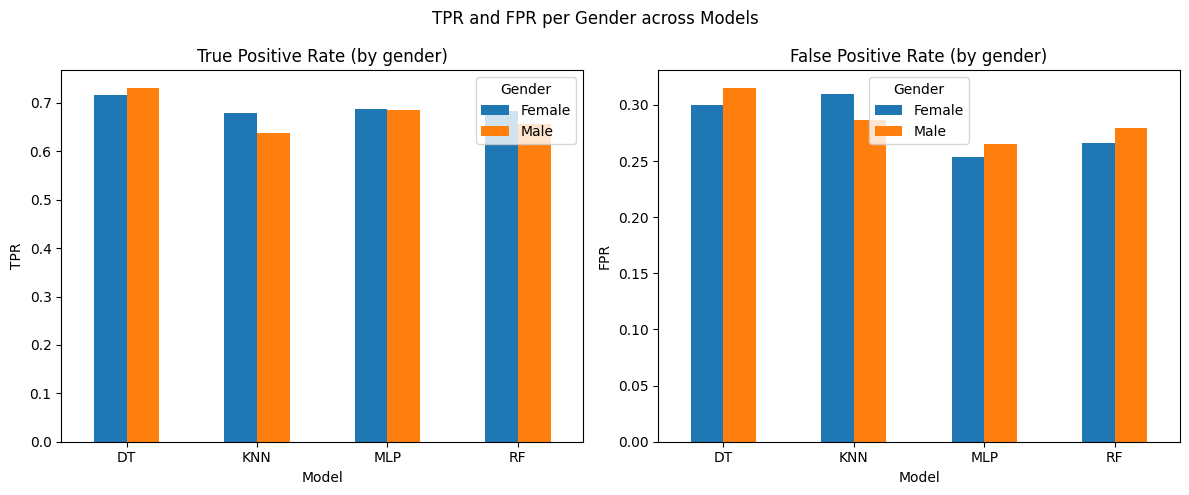

In [57]:
import matplotlib.pyplot as plt

# Collect per-model, per-gender TPR/FPR from your stored MetricFrame tables
rows = []
for model, res in fairlearn_results.items():
    mf = res["MetricFrame"]              
    for g in mf.index:                    
        rows.append({"Model": model, "Gender": g, "TPR": mf.loc[g, "tpr"], "FPR": mf.loc[g, "fpr"]})
df_plot = pd.DataFrame(rows)

# Make gender labels 
df_plot["Gender"] = df_plot["Gender"].map({0: "Female", 1: "Male"}).fillna(df_plot["Gender"])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# TPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="TPR").plot.bar(ax=axes[0], rot=0, legend=True)
axes[0].set_title("True Positive Rate (by gender)")
axes[0].set_ylabel("TPR")

# FPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="FPR").plot.bar(ax=axes[1], rot=0, legend=True)
axes[1].set_title("False Positive Rate (by gender)")
axes[1].set_ylabel("FPR")

plt.suptitle("TPR and FPR per Gender across Models")
plt.tight_layout()
plt.show()

# Interpretation of TPR and FPR by Gender Across Models

Across all models, gender differences in true positive rates (TPR) and false positive rates (FPR) remain relatively small, though distinct patterns emerge. Decision Trees show slightly higher TPR and FPR for males, indicating a minor male disadvantage. KNN favors females, who benefit from higher TPR but also face more false positives, likely due to the training imbalance (75% male, 25% female). The MLP model is the most balanced, with nearly identical TPR and FPR values across genders, suggesting strong robustness to imbalance. Random Forest gives a slight female advantage, with females achieving higher TPR and lower FPR than males.

---

## Takeaways
- **MLP** is the fairest, with nearly identical performance across genders.  
- **DT and RF** are fairly balanced but show small male disadvantages.  
- **KNN** is least fair, amplifying disparities and favoring females.  

---

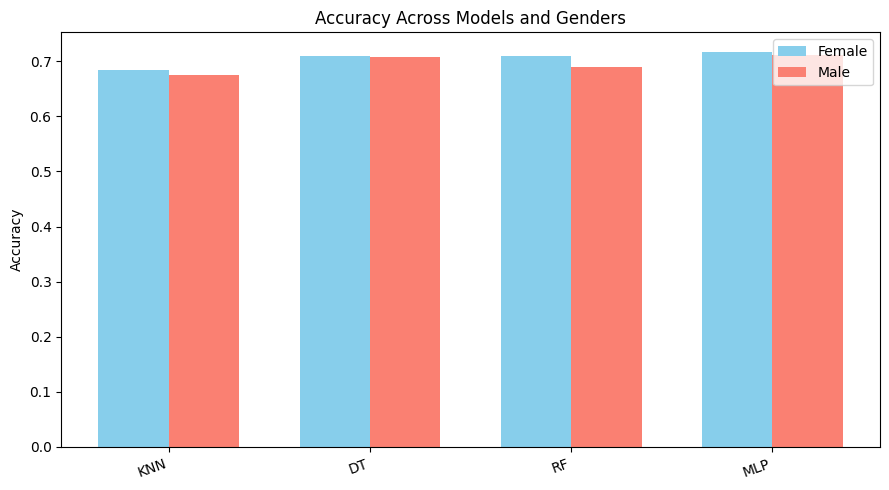

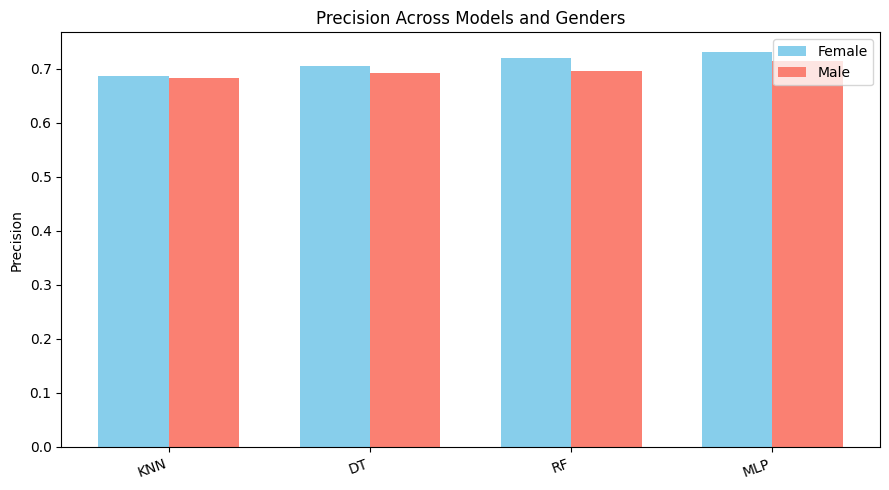

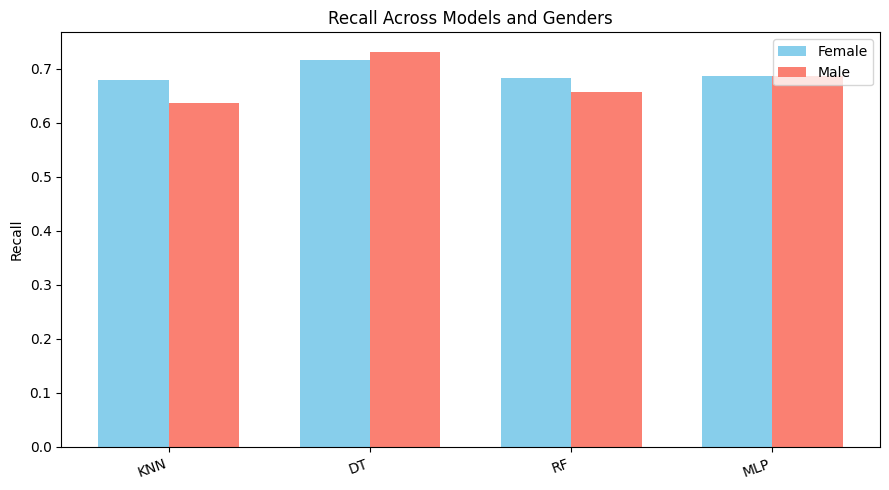

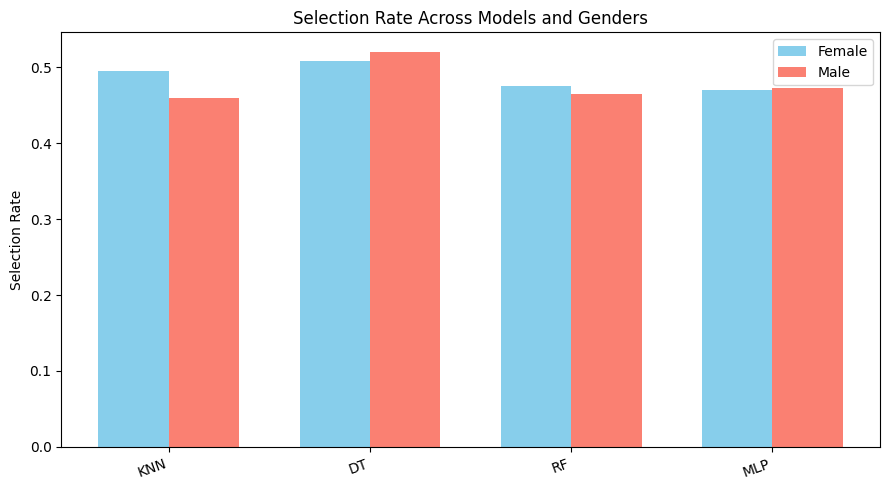

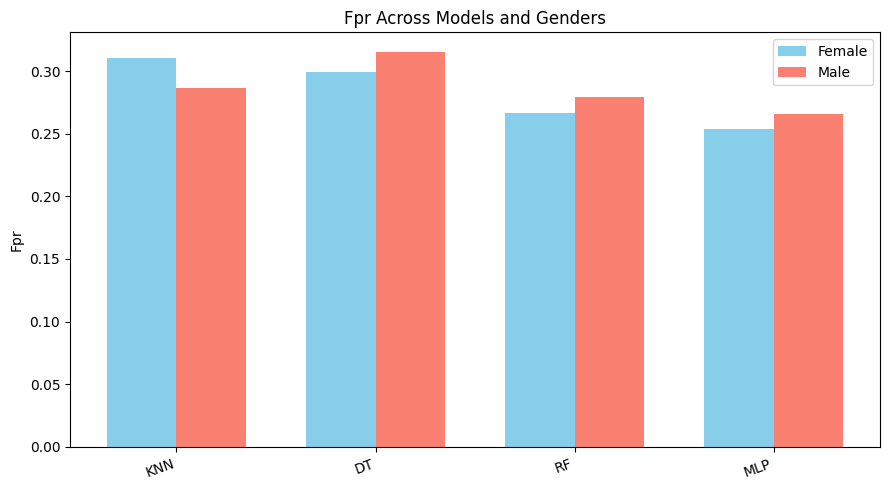

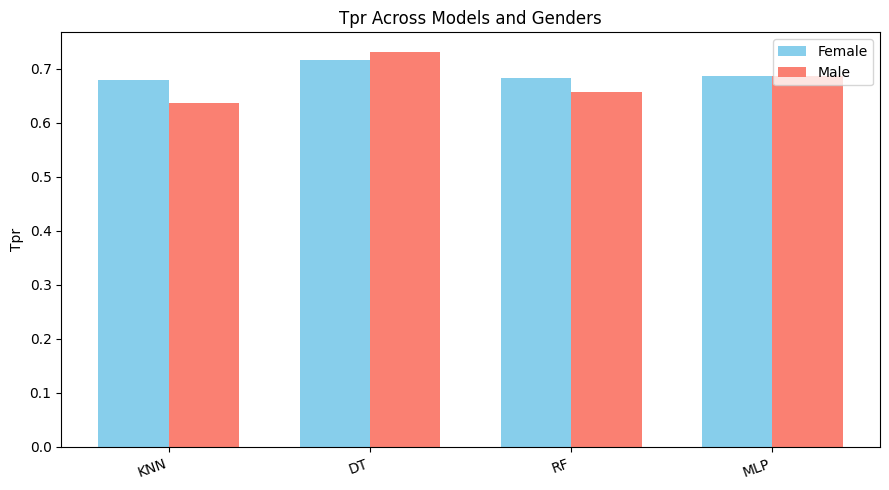

In [58]:
# visualize the comparison
import matplotlib.pyplot as plt
import numpy as np

# Data
models = list(fairlearn_results.keys())

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

metrics = ['accuracy', 'precision', 'recall', 'selection_rate', 'fpr', 'tpr']
genders = [0, 1]
gender_labels = {0: 'Female', 1: 'Male'}
colors = ['skyblue', 'salmon']

for metric in metrics:
    plt.figure(figsize=(9, 5))
    for idx, gender in enumerate(genders):
        values = [
            fairlearn_results[model]["MetricFrame"].loc[gender][metric]
            for model in models
        ]
        positions = np.arange(len(models)) + idx * 0.35
        plt.bar(positions, values, width=0.35, label=gender_labels[gender], color=colors[idx])
    
    plt.xticks(np.arange(len(models)) + 0.35 / 2, short_labels, rotation=20, ha='right')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{metric.replace('_', ' ').title()} Across Models and Genders")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Interpretation of Fairness Metrics Across Models and Genders

Across all models, gender differences are relatively small, but some patterns are consistent.  

Accuracy remains similar for both genders across models, with females performing marginally better in KNN, RF, and MLP, while DT shows near parity. Precision follows a similar trend: females achieve slightly higher values in all models, meaning they are less prone to false positives.  

Recall (or TPR) highlights more variation: KNN favors females (notably higher recall), DT favors males (higher recall), while RF and MLP remain more balanced, with only small differences. Selection rates are generally close, though KNN favors females, and DT slightly favors males; RF and MLP are nearly balanced.  

In terms of errors, FPR is higher for females in KNN, but higher for males in DT, RF, and MLP. This indicates that KNN penalizes females with more false alarms, whereas the other models lean slightly toward males. TPR results align with recall: females are advantaged in KNN and RF, males in DT, and MLP remains the most balanced overall.  

---

## Takeaways
- **MLP** is the fairest model, showing near-equal accuracy, precision, recall, and error rates across genders.  
- **DT** is also balanced but gives a small advantage to males in recall/TPR.  
- **RF** favors females in both recall and FPR (slight male disadvantage).  
- **KNN** is the least fair, giving females higher recall and selection but also a higher false positive rate.  

---